In [2]:
import glob
import pickle

kuka_raw = []

for path in glob.glob('../data/block-stack/kuka_expert_12k_n10_v2_f10/*.pkl'):
    with open(path, 'rb') as f:
        kuka_raw.append(pickle.load(f))

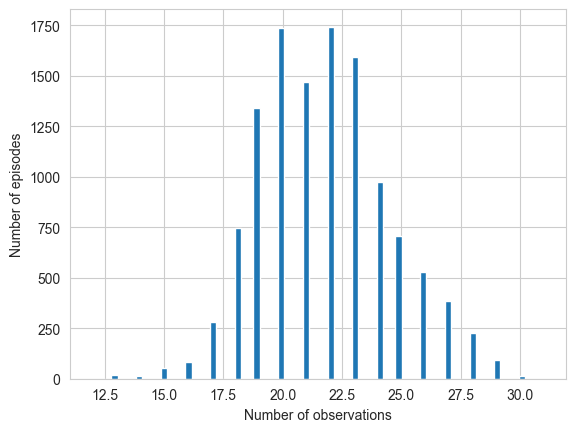

In [3]:
import matplotlib.pyplot as plt

it_counts = [
    len(ep)
    for part in kuka_raw
    for ep in part
]

plt.hist(it_counts, bins='auto')
plt.xlabel('Number of observations')
plt.ylabel('Number of episodes')
plt.show()

In [8]:
import numpy as np

def reduce_state(state: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    (
        *_,
        joints, eff_xyz,
        _, _
    ) = np.split(state, [3, 7, 10, 14, 21, 24, 28])

    return joints, eff_xyz

In [9]:
import numpy as np
from tqdm import tqdm

n_joints = 7

fwd_data = []
inv_data = []

eff_changes = []

raw_data = kuka_raw

for idx, data in enumerate(raw_data):
    for ep in tqdm(data, desc=f'Dataset {idx + 1}/{len(raw_data)}'):
        joints_0, eff_xyz_0 = reduce_state(ep[0])

        assert len(joints_0) == n_joints
        assert len(eff_xyz_0) == 3

        for s in ep[1:]:
            joints_1, eff_xyz_1 = reduce_state(s)

            a = joints_1 - joints_0
            eff_changes.append(eff_xyz_1 - eff_xyz_0)

            s0 = np.concatenate([joints_0, eff_xyz_0])
            s1 = np.concatenate([joints_1, eff_xyz_1])

            fwd_data.append((np.concatenate((s0, a)), s1))
            inv_data.append((np.concatenate((s0, s1)), a))

            joints_0 = joints_1
            eff_xyz_0 = eff_xyz_1

Dataset 6/6: 100%|██████████| 2000/2000 [00:00<00:00, 6911.73it/s]


In [10]:
X_fwd, y_fwd = map(np.asarray, zip(*fwd_data))
X_inv, y_inv = map(np.asarray, zip(*inv_data))

In [11]:
import h5py

with h5py.File('../data/kinematics/kuka_expert_causal_12k_n10_v2_f10.h5', 'w') as hf:
    hf.create_dataset('kuka_kinematics_fwd', data=np.hstack((X_fwd, y_fwd)))
    hf.create_dataset('kuka_kinematics_inv', data=np.hstack((X_inv, y_inv)))

In [12]:
import numpy as np
from tqdm import tqdm

raw_data = kuka_raw
train_data = []

for idx, data in enumerate(raw_data):
    for ep in tqdm(data, desc=f'Dataset {idx + 1}/{len(raw_data)}'):
        s0_joints, s0_eff = reduce_state(ep[0])

        start = np.concatenate([s0_joints, s0_eff])
        end = np.concatenate(reduce_state(ep[-1]))

        x = (start, end)
        traj = []
        
        s0 = start
        joints_0 = s0_joints
        
        traj.append(s0)

        for s in ep[1:]:
            joints_1, s_eff = reduce_state(s)
            s = np.concatenate([joints_1, s_eff])

            a = joints_1 - joints_0
            traj.append(a)
            traj.append(s)
            
            s0 = s
            joints_0 = joints_1
            
        train_data.append((x, traj))

Dataset 6/6: 100%|██████████| 2000/2000 [00:00<00:00, 9137.25it/s]


In [13]:
X = []
y_s = []
y_a = []

for endpoints, traj in tqdm(train_data):
    endpoints = np.concatenate(endpoints)
    
    a_traj = []
    s_traj = []
    
    for i, x in enumerate(traj):
        if i % 2 == 0:
            s_traj.append(x)
        else:
            a_traj.append(x)
    
    s_arr = np.vstack(s_traj)
    a_arr = np.vstack(a_traj)
    
    s_arr = np.pad(s_arr, ((0, 40 - s_arr.shape[0]), (0, 0)), 'edge')
    a_arr = np.pad(a_arr, ((0, 40 - a_arr.shape[0]), (0, 0)), 'constant')
    
    y_s.append(s_arr)
    y_a.append(a_arr)
    X.append(endpoints)

100%|██████████| 12000/12000 [00:00<00:00, 23540.51it/s]


In [14]:
X = np.array(X)
y_s = np.array(y_s)
y_a = np.array(y_a)

In [15]:
import h5py

with h5py.File('../data/kinematics/kuka_expert_traj_12k_n10_v2_f10_edge-pad.h5', 'w') as hf:
    hf.create_dataset('kuka_kinematics_endpoints', data=X)
    hf.create_dataset('kuka_kinematics_trajS', data=y_s)
    hf.create_dataset('kuka_kinematics_trajA', data=y_a)